In [1]:
# General
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import time

# sklearn
from sklearn import cluster, metrics
from sklearn import manifold, decomposition, preprocessing, model_selection
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Tensorflow
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Bert
import os
import transformers
from transformers import *
os.environ["TF_KERAS"]='1'

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-10-13 13:14:34.843623: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-13 13:14:35.833786: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/anaconda/envs/jupyter_env/lib/python3.8/site-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/anaconda/envs/jupyter_env/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www

Num GPUs Available:  0


# Select texts and merge

In [2]:
# Nombre de textes à fusionner 
nb_txt = 50

In [3]:
def import_txt(input):
    import os
    text = input.dict()

    # Récupérez l'URL du fichier texte de la pièce qui nous intéresse
    file_url = text['url_']

    # Faites une requête HTTP pour télécharger le contenu du fichier texte
    file_response = requests.get(file_url)

    # Vérifiez si le téléchargement a réussi (statut code 200)
    if file_response.status_code == 200:
        # Enregistrez le contenu dans un fichier local (par exemple "doc.txt")
        doc = os.path.basename(file_url)
        with open(doc, 'wb') as file:
            file.write(file_response.content)
        print("Le fichier a été téléchargé avec succès.\n")
    else:
        pass
        print("Le téléchargement du fichier a échoué avec le code de statut :", file_response.status_code)

    df=pd.read_fwf(doc,header=None,sep=" ",encoding = "ISO-8859-1")
    return df

In [4]:
# URL de la page web à scraper
url = 'http://www.theatre-classique.fr/pages/programmes/PageEdition.php'

# Faites une requête HTTP pour obtenir le contenu de la page
response = requests.get(url)

# Vérifiez si la requête a réussi (statut code 200)
if response.status_code == 200:
    # Utilisez BeautifulSoup pour analyser le contenu HTML de la page
    soup = BeautifulSoup(response.text, 'html.parser')
    
    # Créez une liste vide pour stocker les éléments href se terminant par '.txt'
    txt_links = []
    
    # Trouvez tous les éléments <a> ayant un attribut href se terminant par '.txt'
    elements = soup.find_all('a', href=lambda href: href and href.endswith('.txt'))

    # Parcourez les éléments trouvés et modifiez l'attribut href pour remplacer '../txt/' par 'http://www.theatre-classique.fr/pages/txt/'
    for element in elements:
        href_value = element['href']
        new_href = href_value.replace('../txt/', 'http://www.theatre-classique.fr/pages/txt/')
        element['href'] = new_href
    # et ajoutez leur contenu (liens) à la liste txt_links
        txt_links.append(new_href)
else:
    print('La requête a échoué avec le code de statut :', response.status_code)

In [5]:
# fonction pour sdupprimer la partie introductive de chaque texte
def supp_intro(df):
    try:
        # Trouver l'index de la première ligne dont le texte commence par 'ACTE I'
        index_to_keep = df[df.loc[:,0].str.startswith('ACTE I')].index[0]
        
        # Si l'index est différent de zéro, supprimer les lignes au-dessus
        if index_to_keep != 0:
            df = df[index_to_keep:]            
        
        # Réinitialiser les index après la suppression
        df.reset_index(drop=True, inplace=True)
        return df
        
        # Maintenant, df contient les lignes après la première ligne commençant par 'ACTE I'
    except:
        return pd.DataFrame()

In [6]:
# mise en place du df qui concatene tous les textes choisis
df = pd.DataFrame()
for link in txt_links[0:nb_txt]:
    txt = pd.read_fwf(link,header=None,sep=" ",encoding = "ISO-8859-1")
    txt = supp_intro(txt)
    df = pd.concat([df,txt],ignore_index=True)

In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,148
0,ACTE I,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"SCÈNE I. Argélie, Clytie.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ARGÉLIE.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Gardes, faites venir Phoenix, et Timagène, Vou...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CLYTIE.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Vérification qu'on n'a plus les notes introductives en début de texte
df.loc[df.iloc[:,0].str.contains('DC'),:]

,0,1,2,3,4,5,6,7,8,9,...,139,140,141,142,143,144,145,146,147,148


# Tokenize and label texts : structure, note, tirade

In [9]:
df_ = df.copy()
# On enlève la ponctuation et on tokenize
from nltk.tokenize import RegexpTokenizer
for c in range(0,df_.shape[1]):
    for r in range(0,len(df_)):
        if type(df_.iloc[r,c]) == str :
            tokenizer = RegexpTokenizer(r'\w+')
            df_.at[r,c] = tokenizer.tokenize(df_.iloc[r,c])

# A ce state chaque cellule de df_ contient une liste de mots sans ponctutation

# Rassembler les lignes dans une colonne "cleaned"
from functools import reduce
col = []
for i in range(0, len(df_)):
    col.append(reduce(lambda x,y : x+y if (type(x) == list and type(y) == list) else x, df_[i:i+1].values.tolist()[0]))
df_["cleaned"] = col

# A ce state df_ a en plus une colonne 'cleaned' qui contient la liste de tous les mots de la ligne

# On réduit df_ à une colonne qui contient la liste de tous les mots de la ligne
df_ = pd.DataFrame(df_["cleaned"])

# # Labelliser

# Supprimer les lignes où la col 'cleaned' contient une liste vide
df_ = df_[df_['cleaned'].apply(lambda x: len(x) > 0)]

# Réinitialiser l'index du DataFrame 
df_.reset_index(drop=True, inplace=True)

# On rajoute une colonne label avec les valeurs structure ou note   
def label(x):
    if (x[0].isupper() and len(x[0])>1):
        return 'structure'
    elif 'Note' in x:
        return 'note'
    else:
        return 'tirade'  # par défaut si aucune condition n'est satisfaite

df_['label'] = df_['cleaned'].map(label)

# A ce stade df_ contient deux colonnes : 'cleaned' et 'label' qui contient structure, note ou None

data = df_.copy()

# Supprimer les lignes où la col 'cleaned' contient une liste vide
df_ = df_[df_['cleaned'].apply(lambda x: len(x) > 0)]

# Réinitialiser l'index du DataFrame 
df_.reset_index(drop=True, inplace=True)

In [10]:
# Regardons l'équilibre des classes
df_['label'].value_counts()

label
tirade       4744
structure    3379
note           24
Name: count, dtype: int64

In [11]:
# On vérifie ici où se trouve le mot 'note' dans chaque ligne
#filtered_df = df_.loc[df_['cleaned'].str.contains('note'), ['cleaned']]
filtered_df = df_[df_['cleaned'].apply(lambda x: 'Note' in x)].reset_index(drop=True)

# Cela renverra les lignes où la colonne 'cleaned' contient 'note'
filtered_df

,cleaned,label
0,"[Et, vous, ne, pouvez, plus, souffrir, auprès,...",note
1,"[Ils, l, ont, appris, aussi, Seigneur, mais, i...",note
2,"[Qu, aux, caprices, du, sexe, un, peuple, ait,...",note
3,"[Note, Diligence, loc, adv, Promptement, en, t...",note
4,"[Quoique, de, quelques, chefs, Coriolan, dispo...",note
5,"[Pour, être, époux, et, roi, n, attend, plus, ...",note
6,"[Note, Dircée, Dans, la, mythologie, grecque, ...",note
7,"[Note, Georges, Dandin, est, une, comédie, de,...",note
8,"[Note, Aune, bâton, d, une, certaine, longueur...",note
9,"[Note, Quadrille, contredanse, que, l, on, pra...",note


In [12]:
# Où se trouve le mot note dans les lignes concernées. Quel est l'indice max.
pst_note = list(map(lambda x : x.index('Note'),filtered_df['cleaned']))
max(pst_note)

39

In [13]:
# Pour définir une max_length cohérent pour BERT
if max(pst_note) > 4:
    max_length = max(pst_note) + 1
else:
    max_length = 5

# Train test split

In [14]:
# Ajustement du nombre de tokens pour optimiser le temps de traitement
df_['cleaned'] = [x[:max_length-1] if len(x) > max_length else x for x in df_['cleaned']]

In [15]:
# Vérifions qu'on a le bon nombre de lignes avec le mot note après l'ajustement 
# de longueur des phrases pour BERT
len(df_[df_['cleaned'].apply(lambda x: 'Note' in x)]) == len(filtered_df)

False

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_['cleaned'],df_['label'], test_size=0.25, random_state=54)

In [17]:
from imblearn.over_sampling import RandomOverSampler

# Instanciez l'objet RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

In [18]:
# Convertissez chaque liste de tokens en une seule chaîne de caractères
X_train_ = [' '.join(tokens) for tokens in X_train]

# Transformez X_train en un tableau NumPy 2D
X_train_ = np.array(X_train_)

# Convertissez les chaînes de caractères en une matrice 2D
X_train_ = np.array(X_train).reshape(-1, 1)

# Maintenant, vous pouvez appliquer l'oversampling
X_resampled, y_resampled = oversampler.fit_resample(X_train_, y_train)

In [19]:
y_resampled.value_counts()

label
structure    3580
tirade       3580
note         3580
Name: count, dtype: int64

# BERT

In [20]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

In [21]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vraies catégories et n° de clusters
def ARI_fct(features, l_cat) :
    time1 = time.time()
    num_labels=len(set(l_cat))
    tsne = manifold.TSNE(n_components=2, 
                                perplexity=2,#30, 
                                n_iter=500, #2000, 
                                init='random', 
                                learning_rate=0.1, #200,
                                random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    
    # #Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)

    le = LabelEncoder()
    y_cat_num = le.fit_transform(y_resampled)

    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),3)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_, time2


# Visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(y_cat_num), loc="best", title="Categorie")#--------------l_cat
    plt.title('Représentation des produits par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)

In [22]:
# Parameters for BERT
# max_length = 7

for diviseur in range(30, 0, -1):
    if len(y_resampled) % diviseur == 0:
        print(f"Le plus grand diviseur inférieur ou égal à 30 est : {diviseur}")
        break  # Sortez de la boucle une fois que vous avez trouvé le diviseur

batch_size = diviseur
model_type = 'bert-base-multilingual-cased'
model = TFAutoModel.from_pretrained(model_type)

#original_list = X_resampled.to_list()
original_list = [x[0] for x in X_resampled.tolist()]
sentences = [' '.join(x) for x in original_list]
#sentences = [' '.join(x) for x in original_list]


loading configuration file config.json from cache at /home/azureuser/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.34.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vo

Le plus grand diviseur inférieur à 10 est : 30


In [23]:
%%time
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at /home/azureuser/.cache/huggingface/hub/models--bert-base-multilingual-cased/snapshots/fdfce55e83dbed325647a63e7e1f5de19f0382ba/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.34.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vo

1/1 [==============================] - 1s 1s/step
temps traitement :  657.0
CPU times: user 13min 40s, sys: 1min 7s, total: 14min 47s
Wall time: 10min 57s


# Model Score

In [25]:
# Display performance
ARI, X_tsne, labels, t_be = ARI_fct(features_bert,y_resampled)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


ARI :  0.028 time :  33.0


In [27]:
le = LabelEncoder()
le.fit(y_resampled)
labels_ = le.inverse_transform(labels)
labels_

array(['tirade', 'tirade', 'tirade', ..., 'tirade', 'tirade', 'tirade'],
      dtype=object)

In [28]:
result = pd.DataFrame()
result['original_list'] = original_list
result['y_resampled'] = y_resampled
result['labels_'] = labels_
result[50:100]

,original_list,y_resampled,labels_
50,"[Que, vos, yeux, lui, gardent, tous, leurs, ch...",tirade,tirade
51,"[SCÈNE, V, Madame, Abraham, Benjamine, Monsieu...",structure,tirade
52,"[Monsieur, MATHIEU]",tirade,tirade
53,"[Terminez, promptement, ensuite, dans, ParisNo...",tirade,tirade
54,"[Et, vous, Alexis, d, un, courage, virilAffron...",tirade,tirade
55,"[MONSIEUR, DAIGLEMONT]",structure,tirade
56,"[Eh, bien]",tirade,structure
57,"[Venez, vous, révoquer, l, Arrêt, de, mon, tré...",tirade,tirade
58,"[Et, je, l, ai, délivré, des, mains, de, ses, ...",tirade,tirade
59,"[Et, je, viens, de, chez, vous, pour, vous, en...",tirade,tirade


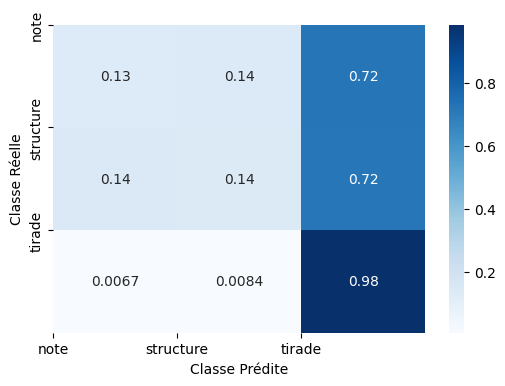

In [31]:
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (6,4))

# Matrice de confusion
conf_mat = sklearn.metrics.confusion_matrix(y_resampled, labels_,normalize = 'true')
sns.heatmap(conf_mat, annot=True, cmap="Blues")

# Redéfinissez les étiquettes des axes x et y
new_xticklabels = le.inverse_transform([0,1,2])
new_yticklabels = le.inverse_transform([0,1,2])

plt.xticks(range(len(new_xticklabels)), new_xticklabels)
plt.yticks(range(len(new_yticklabels)), new_yticklabels)

# Donnez un nom à chaque axe
plt.xlabel("Classe Prédite")
plt.ylabel("Classe Réelle")

# Affichez la heatmap
plt.show()

In [32]:
print(metrics.classification_report(y_resampled, labels_))

              precision    recall  f1-score   support

        note       0.47      0.13      0.21      3580
   structure       0.48      0.14      0.22      3580
      tirade       0.41      0.98      0.58      3580

    accuracy                           0.42     10740
   macro avg       0.45      0.42      0.33     10740
weighted avg       0.45      0.42      0.33     10740

